In [1]:
!pip install -U imblearn

import joblib
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from pycaret.classification import *
import eli5


In [2]:
df = pd.read_csv("data_strokes_prediction.csv")
# drop useless column
df=df.drop(columns='id')

In [3]:
# fill null values with regression on numerical values
DT_bmi_pipe = Pipeline( steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
    
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = round(predicted_bmi)
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [4]:
# ENCODE types object into categories
le = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
       le.fit(df[col])
       df[col] = le.transform(df[col])

In [5]:
X,y = df.drop('stroke', axis = 1), df['stroke']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# augment
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [8]:
# train_data = pd.concat([X_train_res, y_train_res], axis=1)
train_data = pd.concat([X_train_res, y_train_res], axis=1)
s = setup(data=train_data, target='stroke', session_id=123, normalize=True)

,Description,Value
0,Session id,123
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(7802, 11)"
4,Transformed data shape,"(7802, 11)"
5,Transformed train set shape,"(5461, 11)"
6,Transformed test set shape,"(2341, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [9]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9544,0.9916,0.9645,0.9457,0.9549,0.9088,0.9092,0.0410
lightgbm,Light Gradient Boosting Machine,0.9456,0.9889,0.9597,0.9336,0.9464,0.8912,0.8917,0.1970
rf,Random Forest Classifier,0.9429,0.9881,0.9634,0.9255,0.9440,0.8857,0.8866,0.2370
et,Extra Trees Classifier,0.9398,0.9876,0.9627,0.9207,0.9411,0.8795,0.8806,0.0730
dt,Decision Tree Classifier,0.9092,0.9092,0.9279,0.8947,0.9108,0.8183,0.8192,0.0250
gbc,Gradient Boosting Classifier,0.8740,0.9504,0.9030,0.8537,0.8775,0.7480,0.7495,0.0300
knn,K Neighbors Classifier,0.8682,0.9353,0.9414,0.8214,0.8772,0.7363,0.7446,0.4630
ada,Ada Boost Classifier,0.8368,0.9212,0.8601,0.8220,0.8405,0.6737,0.6747,0.0300
qda,Quadratic Discriminant Analysis,0.8211,0.8998,0.8667,0.7946,0.8290,0.6422,0.6451,0.0180
ridge,Ridge Classifier,0.8136,0.0000,0.8470,0.7943,0.8197,0.6272,0.6287,0.1770


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [10]:
best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [11]:

compare_models(sort="AUC", probability_threshold=0.80)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9489,0.9916,0.9118,0.9850,0.9469,0.8978,0.9005,0.0310
lightgbm,Light Gradient Boosting Machine,0.9273,0.9889,0.8704,0.9824,0.9228,0.8546,0.8604,0.1000
rf,Random Forest Classifier,0.9163,0.9881,0.8517,0.9782,0.9105,0.8326,0.8398,0.0830
et,Extra Trees Classifier,0.9390,0.9876,0.8938,0.9828,0.9360,0.8781,0.8819,0.0740
gbc,Gradient Boosting Classifier,0.8178,0.9504,0.6679,0.9540,0.7855,0.6356,0.6664,0.0280
knn,K Neighbors Classifier,0.8819,0.9353,0.8909,0.8754,0.8829,0.7638,0.7642,0.0360
ada,Ada Boost Classifier,0.4999,0.9212,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310
dt,Decision Tree Classifier,0.9092,0.9092,0.9279,0.8947,0.9108,0.8183,0.8192,0.0200
qda,Quadratic Discriminant Analysis,0.8052,0.8998,0.7316,0.8580,0.7896,0.6103,0.6173,0.0210
lr,Logistic Regression,0.7290,0.8915,0.5262,0.8859,0.6599,0.4580,0.5013,0.0210


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

CustomProbabilityThresholdClassifier(base_score=None, booster='gbtree',
                                     callbacks=None,
                                     classifier=XGBClassifier(base_score=None,
                                                              booster='gbtree',
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=None,
                                                              gpu_id=None,
                                                              grow_policy=No...
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='binary:logistic', ...)

In [12]:
# this function trains and evaluates a model using cross validation that can be set with fold parameter. 
# The output prints a score
xg = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9470,0.9905,0.9307,0.9623,0.9462,0.8940,0.8945
1,0.9670,0.9945,0.9780,0.9570,0.9674,0.9341,0.9343
2,0.9487,0.9907,0.9560,0.9422,0.9491,0.8974,0.8975
3,0.9670,0.9930,0.9707,0.9636,0.9672,0.9341,0.9341
4,0.9505,0.9907,0.9560,0.9457,0.9508,0.9011,0.9012
5,0.9652,0.9931,0.9853,0.9472,0.9659,0.9304,0.9312
6,0.9414,0.9891,0.9597,0.9258,0.9424,0.8828,0.8834
7,0.9469,0.9918,0.9670,0.9296,0.9479,0.8938,0.8945
8,0.9597,0.9895,0.9634,0.9564,0.9599,0.9194,0.9194


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
scores = cross_val_score(xg, X_train_res, y_train_res, cv=20)

In [14]:
scores

array([0.66240409, 0.97442455, 0.97948718, 0.96923077, 0.97179487,
       0.97692308, 0.98461538, 0.96410256, 0.97435897, 0.96923077,
       0.96923077, 0.96923077, 0.96923077, 0.97948718, 0.97179487,
       0.98205128, 0.96666667, 0.98717949, 0.97179487, 0.96923077])

In [20]:
tuned_xg = tune_model(xg, custom_grid = {'learning_rate': np.arange(-1,1,0.5)})

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9671,0.9935,0.9562,0.9776,0.9668,0.9342,0.9344
1,0.9560,0.9955,0.9853,0.9308,0.9573,0.9121,0.9137
2,0.9377,0.9901,0.9560,0.9223,0.9388,0.8755,0.8760
3,0.9597,0.9928,0.9670,0.9531,0.9600,0.9194,0.9195
4,0.9524,0.9918,0.9487,0.9557,0.9522,0.9048,0.9048
5,0.9615,0.9945,0.9927,0.9345,0.9627,0.9231,0.9249
6,0.9396,0.9870,0.9560,0.9255,0.9405,0.8791,0.8796
7,0.9560,0.9933,0.9707,0.9431,0.9567,0.9121,0.9125
8,0.9634,0.9916,0.9634,0.9634,0.9634,0.9267,0.9267


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [15]:
preds = predict_model(xg)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9603,0.9919,0.9615,0.9591,0.9603,0.9205,0.9205


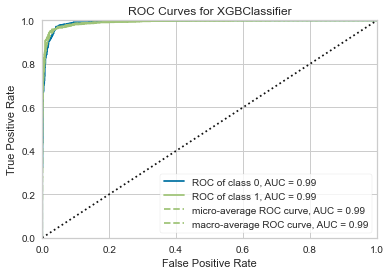

In [16]:
plot_model(xg)

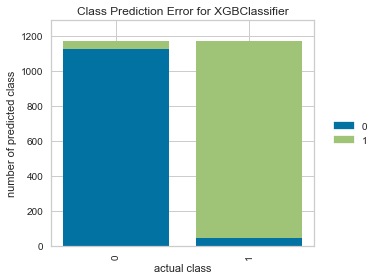

In [17]:
plot_model(xg, plot = 'error')

In [18]:

evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [26]:
final_xg = finalize_model(tuned_xg)
final_xg.get_params()

{'memory': FastMemory(location=C:\Users\ariai\AppData\Local\Temp\joblib),
 'steps': [('numerical_imputer',
   TransformerWrapper(exclude=None,
                      include=['gender', 'age', 'hypertension', 'heart_disease',
                               'ever_married', 'work_type', 'Residence_type',
                               'avg_glucose_level', 'bmi', 'smoking_status'],
                      transformer=SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                keep_empty_features=False,
                                                missing_values=nan,
                                                strategy='mean',
                                                verbose='deprecated'))),
  ('categorical_imputer',
   TransformerWrapper(exclude=None, include=[],
                      transformer=SimpleImputer(add_indicator=False, copy=True,
                                        

In [19]:
# save_model(best, 'best_pipeline')